In [1]:
from cProfile import label
import numpy as np
from project_helpers import binomial_pricer, d1, unpack_weights
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from SemiStaticReplication import model
import keras
from tqdm import tqdm
import csv
import time
import imageio


def delta_nn(S_t, normalizer_t, delta_t, r, sigma, weights_t):
    w_1, b_1, w_2, _ = unpack_weights(weights_t)
    mask1_indices = np.where((w_1 >= 0) & (b_1 >= 0))[0] # delta = w_i
    mask2_indices = np.where((w_1 > 0) & (b_1 < 0))[0]   # delta = w_i (N(d1)-1)
    mask3_indices = np.where((w_1 < 0) & (b_1 > 0))[0]   # delta = -w_i N(d_1)
    d1_vec = d1(S_t / normalizer_t, np.abs(b_1 / w_1), delta_t, r, sigma) # weights correspond to normalized stock

    # compute delta wrt normalized stock
    delta = np.sum( w_2[mask1_indices] * w_1[mask1_indices] ) 
    delta += np.sum( w_2[mask2_indices] * w_1[mask2_indices] * norm.cdf(d1_vec[mask2_indices]) )
    delta += np.sum( w_2[mask3_indices] * w_1[mask3_indices] * norm.cdf(-d1_vec[mask3_indices]) )
    return delta / normalizer_t

def delta_binomial(bump, S_t, strike, T, rfr, vol, n, exercise_dates, pf_style, central=False): 
    bumpa = bump / 2 if central else 0
    bumpb = bump / 2 if central else bump
    v0_bumpedb = binomial_pricer(S_t + bumpb, strike, T, rfr, vol, n, exercise_dates, pf_style)[0,0]
    v0_bumpeda = binomial_pricer(S_t - bumpa, strike, T, rfr, vol, n, exercise_dates, pf_style)[0,0]
    return (v0_bumpedb - v0_bumpeda) / bump

def delta_br_nn(bump, S_t, K, r, sigma, N, monitoring_dates, style, nodes):
    weights, v0, normalizers = model(S_t, K, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
    weights, v0_bumped, normalizers = model(S_t + bump, K, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
    return (v0_bumped[0,0] - v0[0,0]) / bump
# otherwise search for paper on greeks bermudan

def gamma_nn(S_t, normalizer_t, delta_t, r, sigma, weights_t):
    w_1, b_1, w_2, _ = unpack_weights(weights_t)
    mask1_indices = np.where(((w_1 > 0) & (b_1 < 0)) | ((w_1 < 0) & (b_1 > 0)) )[0]   # delta = w_i (N(d1)-1)
    d1_vec = d1(S_t / normalizer_t, np.abs(b_1 / w_1), delta_t, r, sigma) # weights correspond to normalized stock

    # compute delta wrt normalized stock
    fraction = norm.pdf(d1_vec[mask1_indices]) / (S_t * sigma * np.sqrt(delta_t))
    gamma = np.sum( w_2[mask1_indices] * np.abs(w_1[mask1_indices]) * fraction ) 
    return gamma / normalizer_t

def gamma_binomial(bump, S_t, strike, T, rfr, vol, n, exercise_dates, pf_style, central=False):
    S_t_copy = S_t
    if central:
        S_t_copy -= bump
    v0 = binomial_pricer(S_t_copy, strike, T, rfr, vol, n, exercise_dates, pf_style)[0,0]
    v0_bumpedb = binomial_pricer(S_t_copy + 2*bump, strike, T, rfr, vol, n, exercise_dates, pf_style)[0,0]
    v0_bumpeda = binomial_pricer(S_t_copy + bump, strike, T, rfr, vol, n, exercise_dates, pf_style)[0,0]
    return (v0_bumpedb - 2*v0_bumpeda + v0) / (bump**2)

In [14]:
S = 44  # Initial stock price
K = 40  # Strike price
T = 1.0  # Time to maturity
r = 0.06  # Risk-free interest rate
sigma = 0.2  # Volatility
N = 50000
nodes = 64
M = 10
monitoring_dates = np.linspace(0, T, M + 1)
style = 'put'
Ss = np.array(np.arange(30, 51, 1, dtype=float))
print(Ss)

[30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50.]


In [104]:
runs = 10

# deltas SSR
deltas_put_nn_36 = np.zeros((runs, 21))
deltas_put_nn_40 = np.zeros((runs, 21))
deltas_put_nn_44 = np.zeros((runs, 21))
for S0 in tqdm(Ss):
    for run in tqdm(range(runs)):
        weights36, option_value36, normalizers36 = model(36, K, r, sigma, N, monitoring_dates, style,
                                                keras.optimizers.Adam(), nodes, 0.001, 0.001)
        weights40, option_value40, normalizers40 = model(40, K, r, sigma, N, monitoring_dates, style,
                                                keras.optimizers.Adam(), nodes, 0.001, 0.001)
        weights44, option_value44, normalizers44 = model(44, K, r, sigma, N, monitoring_dates, style,
                                                keras.optimizers.Adam(), nodes, 0.001, 0.001)
        deltas_put_nn_36[run, int(S0-30)] = delta_nn(S0, normalizers36[0], T/M, r, sigma, weights36[-1])
        deltas_put_nn_40[run, int(S0-30)] = delta_nn(S0, normalizers40[0], T/M, r, sigma, weights40[-1])
        deltas_put_nn_44[run, int(S0-30)] = delta_nn(S0, normalizers44[0], T/M, r, sigma, weights44[-1])

means_36 = np.mean(deltas_put_nn_36)
means_40 = np.mean(deltas_put_nn_40)
means_44 = np.mean(deltas_put_nn_44)
stds_36 = np.std(deltas_put_nn_36)
stds_40 = np.std(deltas_put_nn_40)
stds_44 = np.std(deltas_put_nn_44)
print(means_36)
print(means_40)
print(means_44)
print(stds_36)
print(stds_40)
print(stds_44)


  0%|          | 0/21 [00:00<?, ?it/s]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


  5%|▍         | 1/21 [32:41<10:53:50, 1961.52s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


 10%|▉         | 2/21 [1:02:30<9:48:59, 1859.97s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


 14%|█▍        | 3/21 [1:31:58<9:05:28, 1818.24s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


 19%|█▉        | 4/21 [2:02:18<8:35:17, 1818.66s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


 19%|█▉        | 4/21 [2:06:15<8:56:35, 1893.85s/it]


KeyboardInterrupt: 

In [16]:
# deltas SSR
deltas_put_nn_36 = []
deltas_put_nn_40 = []
deltas_put_nn_44 = []
for S0 in tqdm(Ss):
    deltas_put_nn_36.append(delta_nn(S0, normalizers36[0], T/M, r, sigma, weights36[-1]))
    deltas_put_nn_40.append(delta_nn(S0, normalizers40[0], T/M, r, sigma, weights40[-1]))
    deltas_put_nn_44.append(delta_nn(S0, normalizers44[0], T/M, r, sigma, weights44[-1]))

100%|██████████| 21/21 [00:00<00:00, 2163.82it/s]


In [96]:
# deltas binomial br
deltas_put_br = [] 
for S0 in tqdm(Ss):
    bump = .14 * S0
    deltas_put_br.append(delta_binomial(bump, S0, K, T, r, sigma, 100, monitoring_dates, 'put', central=True))

100%|██████████| 21/21 [00:00<00:00, 64.56it/s]


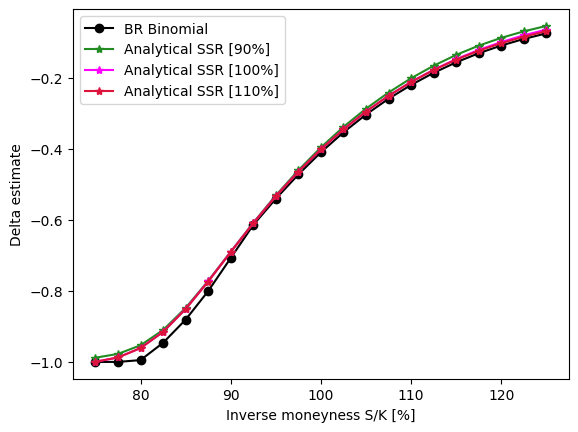

In [97]:
# plot deltas
plt.plot(100 * Ss / K, deltas_put_br, label='BR Binomial', color='black', marker='o')
plt.plot(100 * Ss / K, deltas_put_nn_36, label=f'Analytical SSR [90%]', color='forestgreen', marker='*')
plt.plot(100 * Ss / K, deltas_put_nn_40, label=f'Analytical SSR [100%]', color='magenta', marker='*')
plt.plot(100 * Ss / K, deltas_put_nn_44, label=f'Analytical SSR [110%]', color='crimson', marker='*')
plt.xlabel('Inverse moneyness S/K [%]')
plt.ylabel('Delta estimate')
plt.legend()
plt.savefig(f'Delta_{time.time()}.png', dpi=200, transparent=True)
plt.show()

In [47]:
# gammas SSR
gammas_put_nn_36 = []
gammas_put_nn_40 = []
gammas_put_nn_44 = []
for S0 in tqdm(Ss):
    gammas_put_nn_36.append(gamma_nn(S0, normalizers36[0], T/M, r, sigma, weights36[-1]))
    gammas_put_nn_40.append(gamma_nn(S0, normalizers40[0], T/M, r, sigma, weights40[-1]))
    gammas_put_nn_44.append(gamma_nn(S0, normalizers44[0], T/M, r, sigma, weights44[-1]))

100%|██████████| 21/21 [00:00<00:00, 2798.07it/s]


In [75]:
# gammas binomial br
gammas_put_br = [] 
for S0 in tqdm(Ss):
    bump = .14 * S0
    gammas_put_br.append(gamma_binomial(bump, S0, K, T, r, sigma, 100, monitoring_dates, 'put', central=True))

100%|██████████| 21/21 [00:00<00:00, 42.84it/s]


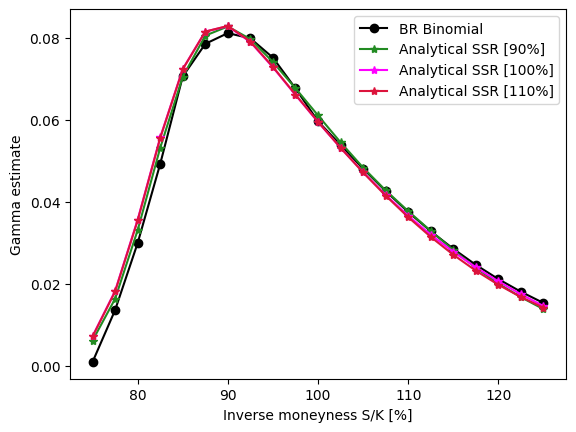

In [98]:
# plot gammas
# plot deltas
plt.plot(100 * Ss / K, gammas_put_br, label='BR Binomial', color='black', marker='o')
plt.plot(100 * Ss / K, gammas_put_nn_36, label=f'Analytical SSR [90%]', color='forestgreen', marker='*')
plt.plot(100 * Ss / K, gammas_put_nn_40, label=f'Analytical SSR [100%]', color='magenta', marker='*')
plt.plot(100 * Ss / K, gammas_put_nn_44, label=f'Analytical SSR [110%]', color='crimson', marker='*')
plt.xlabel('Inverse moneyness S/K [%]')
plt.ylabel('Gamma estimate')
plt.legend()
plt.savefig(f'Gamma_{time.time()}.png', dpi=200, transparent=True)
plt.show()

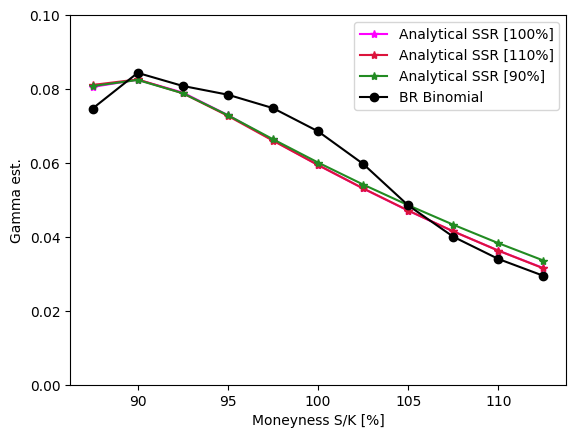

In [10]:
# Plotting

plt.plot(100 * Ss / K, deltas_put_nn, label=f'Analytical SSR [100%]', color='magenta', marker='*')
plt.plot(100 * Ss / K, deltas_put_nn_44, label=f'Analytical SSR [110%]', color='crimson', marker='*')
plt.plot(100 * Ss / K, deltas_put_nn_36, label=f'Analytical SSR [90%]', color='forestgreen', marker='*')

# ax1.plot(100 * Ss / K, deltas_put_br, label='Delta Binomial', color='black', marker='o')
# ax2.plot(100 * Ss / K, gammas_put_br, label='Gamma Binomial', color='black', marker='o')
# ax3.plot(100 * Ss / K, values_put_br, label='Value Binomial', color='black', marker='o')
plt.plot(100 * Ss / K, gammas_put_br, label='BR Binomial', color='black', marker='o')

# Add legend
plt.legend()

# Set x and y axis labels
plt.yticks(np.linspace(0,.1,6))
plt.ylim((0,.1))
plt.xlabel('Moneyness S/K [%]')
plt.ylabel('Gamma est.')

# Save the plot to a file
#plt.savefig(f'GammaSSR_{nodes}nodes_{S/K}moneyness{time.time()}.png', dpi=200, transparent=True)

# Show the plot
plt.show()